## Toy example for DKLP on simulated datasets

In [1]:
from helper import *
from gen_sim_data import *
import matplotlib.pyplot as plt
import numpy as np
import importlib
import matplotlib.cm as cm

### Nonparametric regression

In [2]:
### generate data from nonparameteric regression
# npr_data = gen_data_npr(N=200, d=1, img_shape=[900], kernel='RBF', ls=0.1, var=1, sig=1, n_sim=1)
# save_pickle(npr_data, '../data/NPR_data.pickle')

In [3]:
npr_data = load_pickle('../data/NPR_data.pickle')
sim_data = npr_data['data']
i=0
S = npr_data['grid']
y = sim_data[0]['y']
f = sim_data[0]['f']
V_total = y.shape[0]

Pickle loaded from ../data/NPR_data.pickle


In [4]:
import DKLP_NPR
torch.manual_seed(0)
model = DKLP_NPR.NPR( S=S, y=y, pred_S=S,
         J = 20, H = 128, M=3,
        burnin=1000, thin=1, mcmc_sample=1000,lr=1e-8)
model.fit()
est = model.post_mean()

In [5]:
pred_f = model.post_pred()

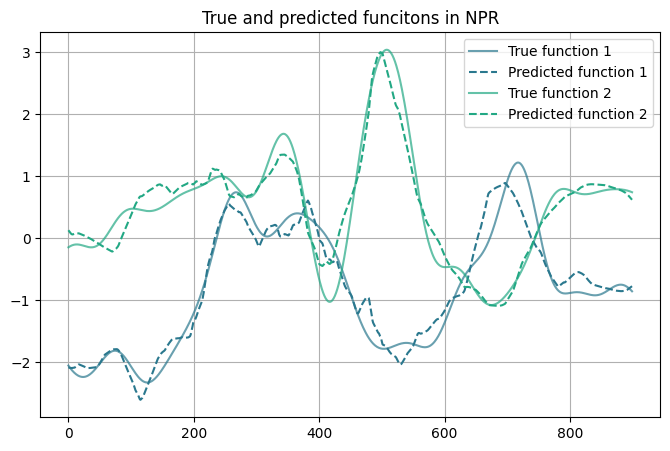

In [6]:
colors = cm.viridis(np.linspace(0.4, 0.8, 3))  
plt.figure(figsize=(8, 5))  

for i in range(2):
    plt.plot(f[:, i], color=colors[i], linestyle='-', label=f'True function {i+1}', alpha=0.7)
    plt.plot(pred_f[:, i], color=colors[i], linestyle='--', label=f'Predicted function {i+1}')

plt.title("True and predicted funcitons in NPR")
plt.legend()
plt.grid(True)
plt.show()

### Image-on-Scalar Regression

In [7]:
is_data = load_pickle('../data/IS_data.pickle')
sim_data = is_data['sim_data']
i=0
S = is_data['true_paras']['grid']
y = sim_data[0]['y']
f = sim_data[0]['f']
X = sim_data[0]['X']
beta = is_data['true_paras']['beta']

Pickle loaded from ../data/IS_data.pickle


In [8]:
import DKLP_IS
torch.manual_seed(0)
is_model = DKLP_IS.IS(  y, X, S, intercept=0,
                L=50, H=256, M=4, act_fn='relu',
                first_burnin=300, second_burnin = 1000, 
                thin=1, mcmc_sample=1000, 
                lr=0.001, batch_size = None)
is_model.fit()


100%|██████████| 2300/2300 [00:16<00:00, 139.90it/s]


In [9]:
is_est = is_model.post_mean_est()
post_delta = is_est[1]
post_beta = is_est[0]
prob_fdr= FDR_IS(post_delta, 0.05, intercept = 0)
maineff = (post_beta * prob_fdr).t().detach().numpy() 

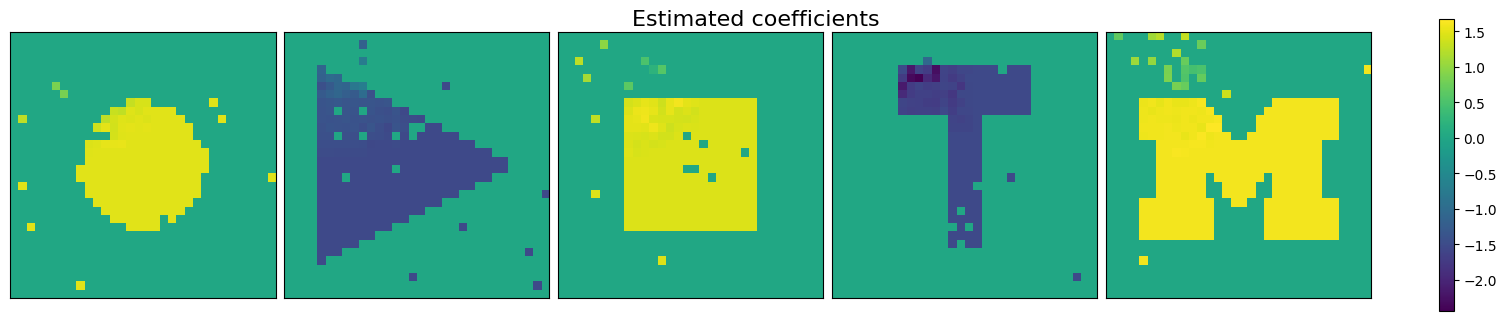

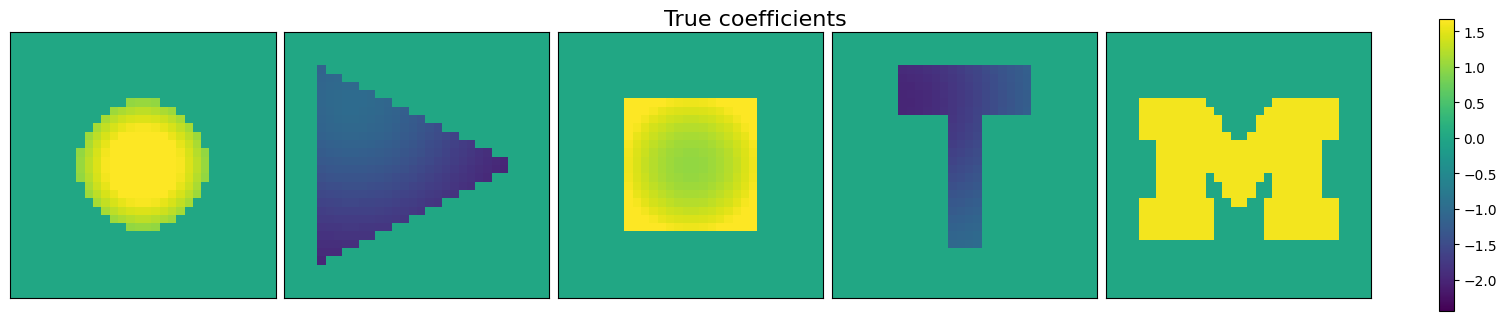

In [10]:
img_min = np.min(maineff)
img_max = np.max(maineff)
J = X.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(15, 3), constrained_layout = True)

for j in range(J):
    ax = axes[j]
    ax.set_xticks([])
    ax.set_yticks([])
    beta_reshape_j = maineff[j,:].reshape((32,32))
    shapes = ax.imshow(beta_reshape_j,vmin=img_min, vmax=img_max)
            
cbar = fig.colorbar(shapes, ax=axes.ravel().tolist())
fig.suptitle("Estimated coefficients", fontsize=16, y=1.02)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(15, 3), constrained_layout = True)
for j in range(J):
    ax = axes[j]
    ax.set_xticks([])
    ax.set_yticks([])
    beta_reshape_j = beta[:,j].reshape((32,32))
    shapes = ax.imshow(beta_reshape_j,vmin=img_min, vmax=img_max)
            
cbar = fig.colorbar(shapes, ax=axes.ravel().tolist())
fig.set_tight_layout
fig.suptitle("True coefficients", fontsize=16, y=1.02)

plt.show()
  

### Scalar-on-Image Regression

In [11]:
si_data = load_pickle('../data/SI_data.pickle')
train_data = si_data['train_data']
i=0
S = si_data['grid']
U = train_data[i][0]
Y = train_data[i][1]
X = train_data[i][2]
beta = si_data['true_paras'][0]

Pickle loaded from ../data/SI_data.pickle


In [12]:
import DKLP_SI 
torch.manual_seed(0)
si_model = DKLP_SI.SI(grid=S, Y= Y, X=X, U=U,
        L = 100, H = 256, include_intercept=0, 
        #threshold= 0,
        kernel_burnin=0, selection_burnin = 1000, 
        thin=1, mcmc_sample=1000,
        lr=0.00001, batch_size=300)
si_model.fit()

100%|██████████| 2000/2000 [01:57<00:00, 16.98it/s]


In [13]:
post_beta, post_delta, post_alpha, post_sigma2_u, post_sigma2_f, post_sigma2_alpha, post_sigma2_nn   = si_model.post_mean_est()
si_est = si_model.post_mean_est()
post_beta = si_est[0]
post_delta = si_est[1]
pred, cutoff,cuoffprob = FDR_SI(post_delta, 0.05)
maineff = (post_beta * pred).t().detach().numpy() 

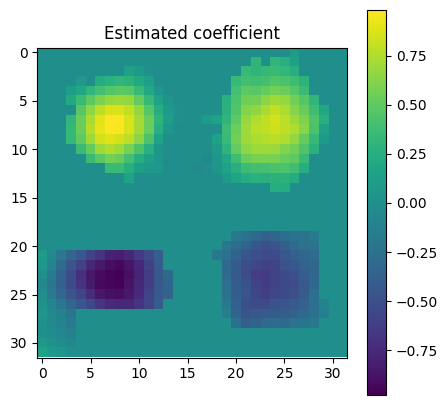

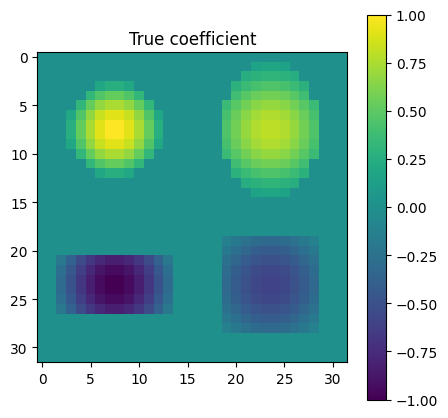

In [110]:
pred, cutoff,cuoffprob = FDR_SI(post_delta, 0.1)
beta_select = post_beta*pred
fig_t=plt.figure(figsize=(5,5))
plt.imshow((beta_select).reshape((32,32)))
plt.title('Estimated coefficient')
plt.colorbar()
fig_t=plt.figure(figsize=(5,5))
plt.imshow((beta).reshape((32,32)))
plt.title('True coefficient')
plt.colorbar()